In [1]:
#package langue
import nltk
import re
from nltk.corpus import stopwords
import math

from string import punctuation
from collections import Counter

In [64]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import plotly.plotly as py
from pylab import savefig
%matplotlib inline

python twitter_streaming.py > twitter_data.txt

## Fonctions de traitement

### Texte

In [3]:
def lower(tweet):
    return tweet.lower()

In [4]:
def retrait_url(tweet):
    p = re.compile('http.*? ')
    if p.search(tweet) :
        result=p.search(tweet).group()
        tweet=tweet.replace(result,'')
    p = re.compile('http(.)*')
    if p.search(tweet) :
        result=p.search(tweet).group()
        tweet=tweet.replace(result,'')
    return tweet

In [5]:
def accents(tweet):
    a=['à','â']
    c=['ç']
    e=['é','è','ê','ë']
    i=['î','ï']
    o=['ô']
    u=['û','ù']
    for lettre in a:
        tweet=tweet.replace(lettre,'a')
    for lettre in c:
        tweet=tweet.replace(lettre,'c')
    for lettre in e:
        tweet=tweet.replace(lettre,'e')
    for lettre in i:
        tweet=tweet.replace(lettre,'i')
    for lettre in o:
        tweet=tweet.replace(lettre,'o')
    for lettre in u:
        tweet=tweet.replace(lettre,'u')
    return tweet

In [6]:
def retrait_chiffre(tweet):
    chiffres=['0','1','2','3','4','5','6','7','8','9']
    for i in chiffres:
        tweet=tweet.replace(i,'')
    return tweet

In [7]:
def separation_mots(tweet):
    tweet=tweet.replace('le pen','lepen')
    return tweet.split(' ')

In [8]:
def retrait_espace(tweet):
    tweet = [word for word in tweet if word !='']
    return tweet

In [9]:
def retrait_stopwords(tweet):
    stopwords = ['alors','au','aux','aucuns','aussi','autre','avant','avec','avoir','bon','ca','car','ce','cela','ces','ceux','chaque','ci','comme','comment','dans','des','du','dedans','dehors','depuis','devrait','doit','donc','dos','debut','elle','elles','en','encore','essai','est','et','eu','fait','faites','fois','font','hors','ici','il','ils','je','la','le','les','leur','ma','maintenant','mais','mes','mine','moins','mon','mot','meme','ni','nommes','notre','nous','ou','par','parce','pas','peut','peu','plupart','pour','pourquoi','quand','que','quel','quelle','quelles','quels','qui','sa','sans','ses','seulement','si','sien','son','sont','sous','soyez','sur','ta','tandis','tellement','tels','tes','ton','tous','tout','trop','tres','tu','voient','vont','votre','vous','vu','etaient','etat','etions','ete','etre','rt']
    tweet = [word for word in tweet if word not in stopwords]
    return tweet

In [10]:
from nltk.stem.snowball import FrenchStemmer
stemmer = FrenchStemmer()

def lemmatisation(tweet):
    for word in tweet :
        word = stemmer.stem(word)     
    return tweet

In [11]:
def retrait_ponctuation(tweet, punctuation_list):
    for p in punctuation_list:
        tweet=tweet.replace(p,' ')
    tweet=tweet.replace('…','')
    tweet=tweet.replace('\n','')
    return tweet

In [12]:
def process_text(row):
    processed_tweet = lower(row['text'])
    processed_tweet = retrait_url(processed_tweet)
    processed_tweet = accents(processed_tweet)
    processed_tweet = retrait_chiffre(processed_tweet)
    processed_tweet = retrait_ponctuation(processed_tweet, list(punctuation))
    processed_tweet = separation_mots(processed_tweet)
    processed_tweet = retrait_espace(processed_tweet)
    processed_tweet = retrait_stopwords(processed_tweet)
    processed_tweet = lemmatisation(processed_tweet)
    return processed_tweet

### Ville

In [13]:
def ville(tweet):
    top_ville=['paris','marseille','lyon','toulouse','nice','nantes','strasbourg','montpellier','bordeaux','lille']
    result=' '
    for ville in top_ville:
        p = re.compile(ville)
        if p.search(tweet) :
            result=p.search(tweet).group()
    return result

### Source

In [14]:
def retrait_balise(tweet):
    p = re.compile('</a>')
    if p.search(tweet) :
        result=p.search(tweet).group()
        tweet=tweet.replace(result,'')
    p = re.compile('<a(.)*>')
    if p.search(tweet) :
        result=p.search(tweet).group()
        tweet=tweet.replace(result,'')
    return tweet

### Candidats

---
- Francois FILLON
- Benoit HAMON
- Emmanuel MACRON
- Jean-Luc MELENCHON
- Jean LASSALLE
- Nicolas DUPONT-AIGNAN
- Nathalie ARTHAUD
- Marine LEPEN
- Francois ASSELINEAU
- Philippe POUTOU
- Jacques CHEMINADE
---

In [15]:
def presence_candidats(tweet,candidat):
    present=0
    for element in candidat:
        present=present + int(element in tweet)
    if present>=1:
        present=1
    return present

## Execution des fonctions

In [115]:
def process_tweet(file_name):
    tweets_data_path = '/Users/saramounir/'+file_name+'.txt'

    tweets_data = []
    tweets_file = open(tweets_data_path, "r")
    for line in tweets_file:
        try:
            tweet = json.loads(line)
            if 'text' in tweet.keys() : 
                tweets_data.append(tweet)
        except:
            continue
    
    tweets = pd.DataFrame()
    
    tweets['text'] = list(map(lambda tweet: tweet['text'], tweets_data))
    tweets['date'] = list(map(lambda tweet: tweet['created_at'], tweets_data))
    tweets['lang'] = list(map(lambda tweet: tweet['lang'], tweets_data))
    tweets['country'] = list(map(lambda tweet: tweet['user']['location'] if tweet['user']['location'] != None else None, tweets_data))
    tweets['user_name'] = list(map(lambda tweet: tweet['user']['name'] if tweet['user']['name'] != None else None, tweets_data))
    tweets['description_user'] = list(map(lambda tweet: tweet['user']['description'] if tweet['user']['description'] != None else None, tweets_data))
    tweets['source'] = list(map(lambda tweet: tweet['source'], tweets_data))
    
    tweets['nb_@']=tweets['text'].apply(lambda x : x.count('@'))
    tweets['nb_rt']=tweets['text'].apply(lambda x : x.count('RT'))
    tweets['text'] = tweets.apply(process_text, axis = 1)
    
    tweets['country']=tweets['country'].fillna(' ')
    tweets['country'] = tweets['country'].apply(lower)
    
    tweets['ville'] = tweets['country'].apply(ville)
    
    tweets['source'] = tweets['source'].apply(retrait_balise)
    
    asselineau=['asselineau','francoisasselineau']
    arthaud=['arthaud','nathaliearthaud']
    cheminade=['cheminade','jacquescheminade']
    dupontaignan=['dupontaignan','nicolasdupontaignan','nda']
    fillon=['fillon','fillongate','francoisfillon','tousfillon','jevotefillon']
    hamon=['benoithamon','jeunesavechamon','hamon']
    lassalle=['jeanlassalle','lassalle']
    lepen=['lepen','mlp','lafrancevotemarine','lepengate','marine','marinelepen','fn']
    macron=['macron','emmanuelmacron']
    melenchon=['jlmelenchon','melenchon','jlm','jeanlucmelenchon']
    poutou=['poutou','philippepoutou']
    
    tweets['asselineau'] = tweets['text'].apply(lambda line: presence_candidats(line,asselineau))
    tweets['arthaud'] = tweets['text'].apply(lambda line: presence_candidats(line,arthaud))
    tweets['cheminade'] = tweets['text'].apply(lambda line: presence_candidats(line,cheminade))
    tweets['dupontaignan'] = tweets['text'].apply(lambda line: presence_candidats(line,dupontaignan))
    tweets['fillon'] = tweets['text'].apply(lambda line: presence_candidats(line,fillon))
    tweets['hamon'] = tweets['text'].apply(lambda line: presence_candidats(line,hamon))
    tweets['lassalle'] = tweets['text'].apply(lambda line: presence_candidats(line,lassalle))
    tweets['lepen'] = tweets['text'].apply(lambda line: presence_candidats(line,lepen))
    tweets['macron'] = tweets['text'].apply(lambda line: presence_candidats(line,macron))
    tweets['melenchon'] = tweets['text'].apply(lambda line: presence_candidats(line,melenchon))
    tweets['poutou'] = tweets['text'].apply(lambda line: presence_candidats(line,poutou))
    
    tweets['nb_candidat']=tweets['asselineau']+tweets['arthaud']+tweets['cheminade']+tweets['dupontaignan']+tweets['fillon']+tweets['hamon']+tweets['lassalle']+tweets['lepen']+tweets['macron']+tweets['melenchon']+tweets['poutou']
    
    return tweets

In [116]:
tweets_mars=process_tweet('twitter_data')

In [117]:
tweets_avril=process_tweet('twitter_data_17avril')

In [75]:
def semi_process_tweet(file_name):
    tweets_data_path = '/Users/saramounir/'+file_name+'.txt'

    tweets_data = []
    tweets_file = open(tweets_data_path, "r")
    for line in tweets_file:
        try:
            tweet = json.loads(line)
            if 'text' in tweet.keys() : 
                tweets_data.append(tweet)
        except:
            continue
    
    tweets = pd.DataFrame()
    
    tweets['text'] = list(map(lambda tweet: tweet['text'], tweets_data))
    tweets['date'] = list(map(lambda tweet: tweet['created_at'], tweets_data))
    tweets['lang'] = list(map(lambda tweet: tweet['lang'], tweets_data))
    tweets['country'] = list(map(lambda tweet: tweet['user']['location'] if tweet['user']['location'] != None else None, tweets_data))
    tweets['user_name'] = list(map(lambda tweet: tweet['user']['name'] if tweet['user']['name'] != None else None, tweets_data))
    tweets['description_user'] = list(map(lambda tweet: tweet['user']['description'] if tweet['user']['description'] != None else None, tweets_data))
    tweets['source'] = list(map(lambda tweet: tweet['source'], tweets_data))
    
    return tweets

In [76]:
tweets_mars_entier=semi_process_tweet('twitter_data')

#### Rajout label

In [118]:
tweet_label=pd.read_excel("/Users/saramounir/Desktop/tweets_23avril_après.xlsx")

In [119]:
label=tweet_label['label']
label
tweets_mars['label']=label

## Graphiques

### Nb tweet/candidat

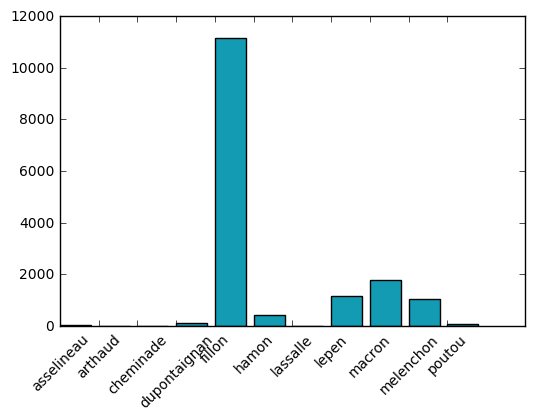

In [67]:
somme=[tweets_mars['asselineau'].sum(),tweets_mars['arthaud'].sum(),tweets_mars['cheminade'].sum(),
      tweets_mars['dupontaignan'].sum(),tweets_mars['fillon'].sum(),tweets_mars['hamon'].sum(),
      tweets_mars['lassalle'].sum(),tweets_mars['lepen'].sum(),tweets_mars['macron'].sum(),
      tweets_mars['melenchon'].sum(),tweets_mars['poutou'].sum()]

candidats=['asselineau','arthaud','cheminade','dupontaignan','fillon','hamon','lassalle','lepen','macron','melenchon','poutou']

y_pos = np.arange(len(candidats))
plt.bar(y_pos,somme,color='#139BB4')
plt.xticks(y_pos,candidats, rotation=45)

savefig('/Users/saramounir/Desktop/Ensae/S2/python/site_sara/v0/Site web/images/home/nb_tweet_candidat.png')

### Nb tweet/ville

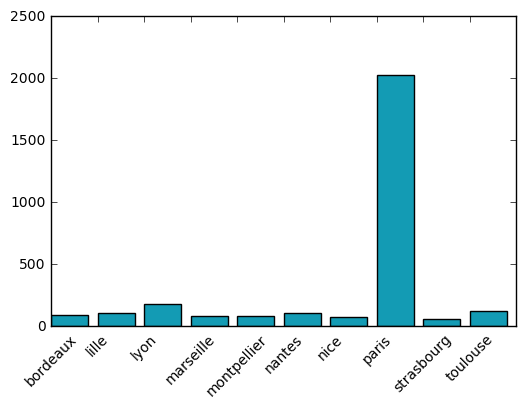

In [68]:
nb_ville=tweets_mars.groupby('ville').count()
count=nb_ville['text'][1:]

villes = ['bordeaux','lille','lyon','marseille','montpellier','nantes','nice','paris','strasbourg','toulouse']
y_pos = np.arange(len(villes))

plt.bar(y_pos,count,color='#139BB4')
plt.xticks(y_pos,villes, rotation=45)

savefig('/Users/saramounir/Desktop/Ensae/S2/python/site_sara/v0/Site web/images/home/nb_tweet_ville.png')

### Nb tweet/source

In [23]:
nb_ville=tweets_mars.groupby('source').count()
count=nb_ville['text'][1:]
#count

#villes = ['bordeaux','lille','lyon','marseille','montpellier','nantes','nice','paris','strasbourg','toulouse']
#y_pos = np.arange(len(villes))

#plt.bar(y_pos,count,color='#139BB4')
#plt.xticks(y_pos,villes, rotation=45)

### Network

In [24]:
network=pd.DataFrame()
for c in candidats:
    t=tweets_mars.loc[tweets_mars[c] == 1]
    t=t[['asselineau','arthaud','cheminade','dupontaignan','fillon','hamon','lassalle','lepen','macron','melenchon','poutou']]
    somme=t.sum()
    network[c]=somme
network

,asselineau,arthaud,cheminade,dupontaignan,fillon,hamon,lassalle,lepen,macron,melenchon,poutou
asselineau,53,0,0,4,2,0,4,2,4,0,5
arthaud,0,13,0,0,0,0,0,0,10,0,0
cheminade,0,0,2,0,0,0,0,0,0,0,0
dupontaignan,4,0,0,113,14,2,4,10,32,1,4
fillon,2,0,0,14,11161,38,1,93,167,342,1
hamon,0,0,0,2,38,419,0,31,92,52,1
lassalle,4,0,0,4,1,0,14,0,4,0,4
lepen,2,0,0,10,93,31,0,1170,110,59,3
macron,4,10,0,32,167,92,4,110,1801,76,66
melenchon,0,0,0,1,342,52,0,59,76,1031,1


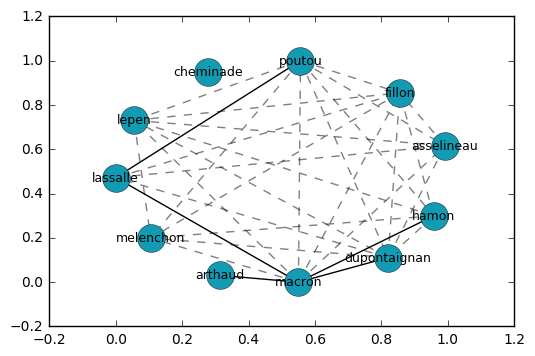

In [66]:
import networkx as nx

candidats=['asselineau','arthaud','cheminade','dupontaignan','fillon','hamon','lassalle','lepen','macron','melenchon','poutou']

G=nx.Graph()
G.add_nodes_from(candidats)

for i in range(0,11) :
    for j in range((i+1),11):
        c1=candidats[i]
        c2=candidats[j]
        w=network.iloc[i,j]/network.iloc[i].sum()
        
        if w>0:
            G.add_edge(c1,c2,weight=w)

elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0.1]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=0.1]

pos=nx.spring_layout(G) # positions for all nodes

nx.draw_networkx_nodes(G,pos,node_size=400,node_color='#139BB4',node_shape='o',linewidths=0.3)

nx.draw_networkx_edges(G,pos,edgelist=elarge,
                    width=1)
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=1,alpha=0.5,style='dashed')

nx.draw_networkx_labels(G,pos,font_size=9,font_family='sans-serif',font_weight='medium')

savefig('/Users/saramounir/Desktop/Ensae/S2/python/site_sara/v0/Site web/images/home/network_graph.png')

### WordCloud

In [83]:
text=''

for i in range(len(tweets_mars_entier)):
    text=text + ' ' + tweets_mars_entier['text'][i]

In [84]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0, max_features=200)
counts = cv.fit_transform([text]).toarray().ravel()                                                  
words = np.array(cv.get_feature_names()) 
# normalize                                                                                                                                             
counts = counts / float(counts.max())

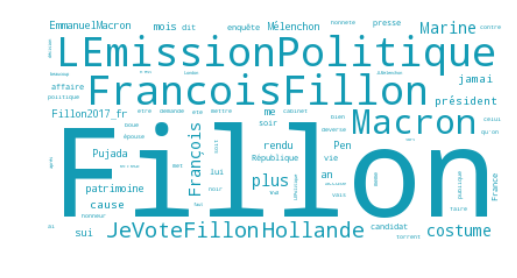

In [107]:
from wordcloud import WordCloud, STOPWORDS

stopwords = ['alors','au','aux','aucuns','aussi','autre','avant','avec','avoir','bon','ca','ça','car','ce','cela',"c'est",'ces','ceux','chaque','ci','co','comme','comment','dans','de','des','du','dedans','dehors','depuis','devrait','doit','donc','dos','debut','elle','elles','en','encore','essai','est','et','eu','fait','faites','fois','font','http','https','hors','ici','il','ils','je',"j'ai",'la','le','les','leur','ma','maintenant','mais','mes','mine','moi','moins','mon','mot','meme','ni','nommes','notre','nous','ne','ou','on','par','parce','pas','peut','peu','plupart','pour','pourquoi','quand','que','quel','quelle','quelles','quels','qui',"qu'il",'sa','sans','ses','se','seulement','si','sien','son','sont','sous','soyez','sur','ta','tandis','tellement','tels','tes','ton','tous','tout','trop','tres','tu','un','une','voient','vont','votre','vous','vu','etaient','etat','etions','ete','etre','rt']

def blue_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "rgb(19,155,180)"

wordcloud = WordCloud(max_words=2000, 
                      #mask=mask, 
                      stopwords=stopwords, 
                      margin=10,
                      background_color="white",
                      random_state=1,
                      color_func=blue_color_func).generate(text)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

plt.savefig('/Users/saramounir/Desktop/Ensae/S2/python/site_sara/v0/Site web/images/home/wordcloud.png')

## Prédiction

In [120]:
train=tweets_mars.loc[tweets_mars['nb_candidat'] == 1]
train=train.dropna()
train = train.drop(["date","lang","country","user_name","description_user","source","nb_@","nb_rt","ville","asselineau","arthaud","cheminade","dupontaignan","fillon","hamon","lassalle","lepen","macron","melenchon","poutou","nb_candidat"], axis=1)

In [121]:
from collections import Counter
X_train = list(train.apply(lambda x:Counter(x['text']), axis = 1))
X_test = list(train.apply(lambda x:Counter(x['text']), axis = 1))

In [122]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=True)
X_train = v.fit_transform(X_train)
X_train

<505x2073 sparse matrix of type '<class 'numpy.float64'>'
	with 5914 stored elements in Compressed Sparse Row format>

In [123]:
X_test = v.transform(X_test)

#### cross validation

In [124]:
from sklearn import cross_validation

print(train.shape)

train_target = train.label
train_data = X_train

# Validation croisée
X = train_data
y = train_target

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,
                                        test_size=0.25, random_state=0)

print("%r, %r, %r" % (X.shape, X_train.shape, X_test.shape))

(505, 2)
(505, 2073), (378, 2073), (127, 2073)


In [31]:
from sklearn import linear_model

logistic = linear_model.LogisticRegression()
logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
# use the model to predict the labels of the test data
y_pred = logistic.predict(X_test)

In [33]:
from sklearn import metrics

print(metrics.confusion_matrix(y_test, y_pred))

print(metrics.classification_report(y_test, y_pred))

[[ 0  4  2]
 [ 0 36 21]
 [ 0 23 16]]
             precision    recall  f1-score   support

       -1.0       0.00      0.00      0.00         6
        0.0       0.57      0.63      0.60        57
        1.0       0.41      0.41      0.41        39

avg / total       0.48      0.51      0.49       102



/Users/saramounir/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



In [34]:
train.head()

,text,label
26,"[roblelama, sochik, jlmelenchon, cas, m, aura,...",0.0
29,"[ionwhite, a, tweet, from, presidential, candi...",0.0
61,"[apres, elections, partisocialiste, va, virer,...",-1.0
69,"[jraas, pablo, melenchon, escobar]",0.0
72,"[ofcaldubkoto, bagong, hamon, para, kila, benj...",0.0


In [35]:
test=tweets_avril.loc[tweets_avril['nb_candidat'] == 1]
test = test.drop(["date","lang","country","user_name","description_user","source","nb_@","nb_rt","ville","asselineau","arthaud","cheminade","dupontaignan","fillon","hamon","lassalle","lepen","macron","melenchon","poutou","nb_candidat"], axis=1)

X_test = list(test.apply(lambda x:Counter(x['text']), axis = 1))
X_test = v.transform(X_test)

# use the model to predict the labels of the test data
y_pred = logistic.predict(X_test)

In [36]:
y_pred

array([ 0.,  0.,  0., ...,  0.,  0.,  1.])

## Score

In [37]:
tweets_avril=tweets_avril.loc[tweets_avril['nb_candidat'] == 1]
tweets_avril['label']=y_pred

In [40]:
def scoring(row):
    if row['label'] == 0:
        return 1
    elif row['label'] == 1:
        return 2
    elif row['label'] == -1:
        return -1

def compute(S):
    return (S['COUNT']*S['SCORE']).sum()

In [47]:
candidats=['asselineau','arthaud','cheminade','dupontaignan','fillon','hamon','lassalle','lepen','macron','melenchon','poutou']
df = pd.DataFrame(columns = ['candidat', 'score'],index = [0,1,2,3,4,5,6,7,8,9,10])
i=0

for candidat in candidats:
    tweet_candidat=tweets_avril.loc[tweets_avril[candidat] == 1]
    nb=tweet_candidat.groupby('label').count()['text']
    
    S = nb.to_frame('COUNT')
    S['SCORE'] = S.reset_index().apply(scoring, axis = 1)
    score = compute(S)
    
    df['candidat'][i]=candidat
    df['score'][i]=score
    
    i=i+1

somme_score=df['score'].sum()

df['score'] = df['score'].apply(lambda line: line/somme_score*100)

In [60]:
df=df.sort_values(by = 'score', ascending = False).reset_index()
df

,index,candidat,score
0,8,macron,40.241408
1,4,fillon,32.119476
2,9,melenchon,13.741135
3,7,lepen,4.821331
4,5,hamon,4.118931
5,0,asselineau,2.379978
6,3,dupontaignan,1.329787
7,10,poutou,0.900164
8,1,arthaud,0.143208
9,6,lassalle,0.109111


In [62]:
print('1er candidat :',df['candidat'][0],' avec un score de ',df['score'][0])
print('2eme candidat :',df['candidat'][1],' avec un score de ',df['score'][1])

1er candidat : macron  avec un score de  40.2414075286
2eme candidat : fillon  avec un score de  32.1194762684


In [127]:
#tweets=tweets[0:500]
#tweets.to_csv("/Users/saramounir/Desktop/tweets_23avril_avant.csv",sep=';')
listei=[]



for i in listei:
    print(i,' : ',tweets_mars_entier['text'][i],'\n')